# Work with ICESat-2 ATL06 Granules Using `earthaccess` and `xarray`
## Getting to analysis in 3-lines of code!



In [1]:
import earthaccess
import xarray as xr

/home/apbarret/mambaforge/envs/project-demo-20240313/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Step 1. Authenticate

I'm using a `.netrc` file to store my EarthdataLogin credentials.  Credentials can also be entered interactively or exported to environment variables.  Whichever method you choose, `earthaccess` streamlines authentication so you don't have to think about it.

In [2]:
auth = earthaccess.login()

### Step 2.  Find some data

We search by `short_name`, `version`, spatial criteria and a time range.  I have also set the code to ignore cloud-hosted data.  Setting `cloud-hosted` to true looks for data in NASA EarthData Cloud in AWS region `us-west-2`.

In [3]:
results = earthaccess.search_data(
    short_name = 'ATL06',
    version = '006',
    cloud_hosted = False,
    bounding_box = (-134.7,58.9,-133.9,59.2),
    temporal = ('2020-03-01','2020-04-30'),
)

Granules found: 4


### Step 3. Access the data

We've found 4 data granules that match our search criteria.

`earthaccess` can be used to download or stream data.  I'm focusing on remote access here.  _Under-the-hood_, `earthaccess` is using `fsspec` to create a virtual file system.  This creates _file-like_ objects that can be passed to `xarray.open_dataset`.

ICESat-2 data are HDF5 files that consist of nested groups of data.  `xarray` can't read the whole HDF5 file into a dataset, so we have to pass a path to our group of interest.  In this case, `land_ice_segments` for beam `gt1l`.

Tools like `xarray-datatree` can read multiple groups. 

In [15]:
%%time
files = earthaccess.open([results[1]], provider="NSIDC")
ds = xr.open_dataset(files[0], group='/gt1l/land_ice_segments', chunks='auto')

Opening 1 granules, approx size: 0.03 GB


QUEUEING TASKS | : 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1363.56it/s]
PROCESSING TASKS | : 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.41it/s]
COLLECTING RESULTS | : 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 8924.05it/s]


CPU times: user 9.34 s, sys: 2.08 s, total: 11.4 s
Wall time: 3min 31s


In [16]:
files

[<File-like object HTTPFileSystem, https://n5eil01u.ecs.nsidc.org/DP5/ATLAS/ATL06.006/2020.03.12/ATL06_20200312233336_11800602_006_01.h5>]

### ...and now for analysis

The granule we accessed is 29 MB.  It took a little over 3 minutes to load it.  The data are stored in memory

In [8]:
ds

<xarray.Dataset> Size: 1MB
Dimensions:                (delta_time: 24471)
Coordinates:
  * delta_time             (delta_time) datetime64[ns] 196kB 2020-03-12T23:40...
    latitude               (delta_time) float64 196kB dask.array<chunksize=(24471,), meta=np.ndarray>
    longitude              (delta_time) float64 196kB dask.array<chunksize=(24471,), meta=np.ndarray>
Data variables:
    atl06_quality_summary  (delta_time) int8 24kB dask.array<chunksize=(24471,), meta=np.ndarray>
    h_li                   (delta_time) float32 98kB dask.array<chunksize=(24471,), meta=np.ndarray>
    h_li_sigma             (delta_time) float32 98kB dask.array<chunksize=(24471,), meta=np.ndarray>
    segment_id             (delta_time) float64 196kB dask.array<chunksize=(24471,), meta=np.ndarray>
    sigma_geo_h            (delta_time) float32 98kB dask.array<chunksize=(24471,), meta=np.ndarray>
Attributes:
    Description:  The land_ice_height group contains the primary set of deriv...
    data_rate:    Data within this group are sparse.  Data values are provide...

We can get a quick plot to visualize the data.

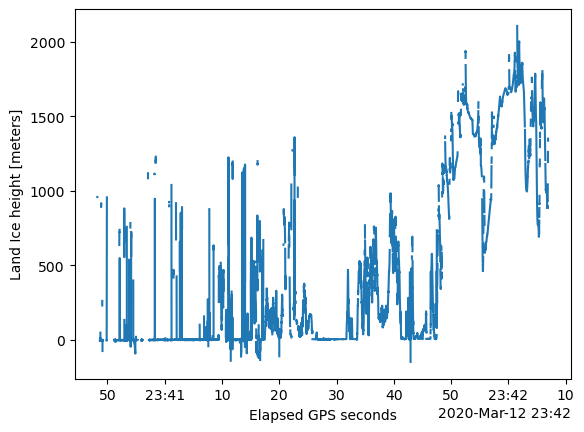

In [9]:
ds.h_li.plot()

## For comparison, download the data

In [10]:
%%time
downloaded_files = earthaccess.download(results[1], local_path="./data")

 Getting 1 granules, approx download size: 0.03 GB


QUEUEING TASKS | : 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 510.75it/s]
PROCESSING TASKS | : 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.74s/it]
COLLECTING RESULTS | : 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11715.93it/s]

CPU times: user 104 ms, sys: 89.8 ms, total: 194 ms
Wall time: 1.75 s


In [11]:
downloaded_files

['data/ATL06_20200312233336_11800602_006_01.h5']

In [12]:
%%time
ds2 = xr.open_dataset(downloaded_files[0], group='/gt1l/land_ice_segments', chunks='auto')

CPU times: user 180 ms, sys: 1.09 ms, total: 182 ms
Wall time: 181 ms


In [13]:
ds2

<xarray.Dataset> Size: 1MB
Dimensions:                (delta_time: 24471)
Coordinates:
  * delta_time             (delta_time) datetime64[ns] 196kB 2020-03-12T23:40...
    latitude               (delta_time) float64 196kB dask.array<chunksize=(24471,), meta=np.ndarray>
    longitude              (delta_time) float64 196kB dask.array<chunksize=(24471,), meta=np.ndarray>
Data variables:
    atl06_quality_summary  (delta_time) int8 24kB dask.array<chunksize=(24471,), meta=np.ndarray>
    h_li                   (delta_time) float32 98kB dask.array<chunksize=(24471,), meta=np.ndarray>
    h_li_sigma             (delta_time) float32 98kB dask.array<chunksize=(24471,), meta=np.ndarray>
    segment_id             (delta_time) float64 196kB dask.array<chunksize=(24471,), meta=np.ndarray>
    sigma_geo_h            (delta_time) float32 98kB dask.array<chunksize=(24471,), meta=np.ndarray>
Attributes:
    Description:  The land_ice_height group contains the primary set of deriv...
    data_rate:    Data within this group are sparse.  Data values are provide...

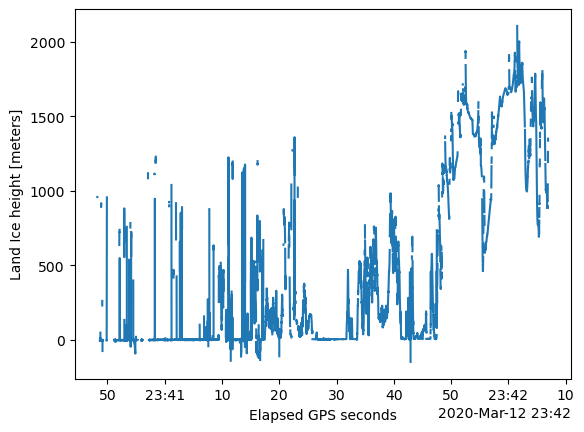

In [14]:
ds2.h_li.plot()